## Statistical Moments

How more moments than just mean and variance can be used to describe data. How to use a Jarque Bera test to check for normality. This is a crucial step in many other analyses, especially regression, as many statistical techniques and variance computations assume normality.

In [25]:
import yfinance as yf
import requests
import datetime
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
from matplotlib import style
from math import pi

import scipy.stats as stats

yf.pdr_override()

When we calculate variance, we square the deviations around the mean. In the case of large deviations, we do not know whether they are likely to be positive or negative. This is where the skewness and symmetry of a distribution come in. A distribution is symmetric if the parts on either side of the mean are mirror images of each other. For example, the normal distribution is symmetric. 

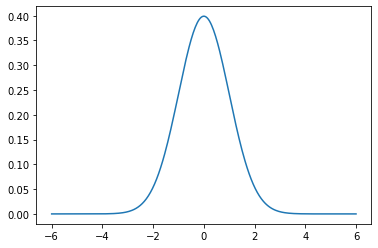

In [26]:
# Plot a normal distribution with mean = 0 and standard deviation = 2
xs = np.linspace(-6,6, 300)
normal = stats.norm.pdf(xs)
plt.plot(xs, normal);

A distribution can have many small positive and a few large negative values (negatively skewed) or vice versa (positively skewed), and still have a mean of 0. A symmetric distribution has skewness 0. Positively skewed unimodal (one mode) distributions have the property that mean > median > mode. Negatively skewed unimodal distributions are the reverse, with mean < median < mode. All three are equal for a symmetric unimodal distribution.

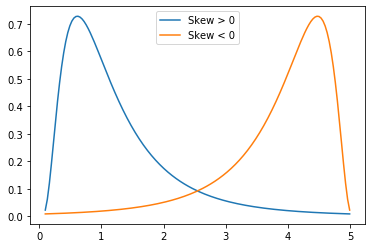

In [27]:
# Generate x-values for which we will plot the distribution
xs2 = np.linspace(stats.lognorm.ppf(0.01, .7, loc=-.1), stats.lognorm.ppf(0.99, .7, loc=-.1), 150)

# Negatively skewed distribution
lognormal = stats.lognorm.pdf(xs2, .7)
plt.plot(xs2, lognormal, label='Skew > 0')

# Positively skewed distribution
plt.plot(xs2, lognormal[::-1], label='Skew < 0')
plt.legend();

Although skew is less obvious when graphing discrete data sets, we can still compute it. For example, below are the skew, mean, and median for S&P 500 returns 2017-2019. The skew is negative, and so the mean is less than the median.

[*********************100%***********************]  1 of 1 completed
Skew: -0.5999760779440603
Mean: 0.00031696535039955166
Median: 0.00048639475440404034


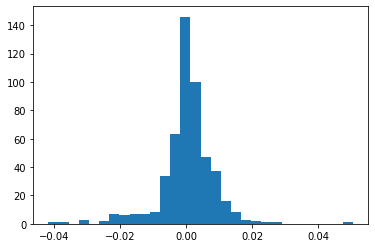

In [28]:
pricing = pdr.get_data_yahoo('SPY', start="2017-01-01", end="2019-01-01", interval = "1d")['Adj Close']
returns = pricing.pct_change()[1:]

print('Skew:', stats.skew(returns))
print('Mean:', np.mean(returns))
print('Median:', np.median(returns))

plt.hist(returns, 30);

### Kurtosis

Kurtosis attempts to measure the shape of the deviation from the mean. Generally, it describes how peaked a distribution is compared the the normal distribution, called mesokurtic. All normal distributions, regardless of mean and variance, have a kurtosis of 3. A leptokurtic distribution (kurtosis > 3) is highly peaked and has fat tails, while a platykurtic distribution (kurtosis < 3) is broad. Sometimes, however, kurtosis in excess of the normal distribution (kurtosis - 3) is used, and this is the default in scipy. A leptokurtic distribution has more frequent large jumps away from the mean than a normal distribution does while a platykurtic distribution has fewer.

Excess kurtosis of leptokurtic distribution: 3.0
Excess kurtosis of mesokurtic distribution: 0.0
Excess kurtosis of platykurtic distribution: -0.5937628755982794


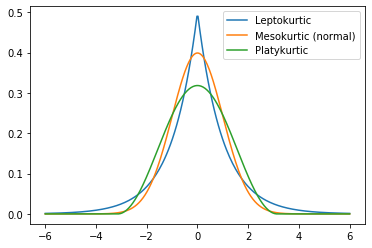

In [29]:
# Plot some example distributions
plt.plot(xs,stats.laplace.pdf(xs), label='Leptokurtic')
print( 'Excess kurtosis of leptokurtic distribution:', (stats.laplace.stats(moments='k')))
plt.plot(xs, normal, label='Mesokurtic (normal)')
print( 'Excess kurtosis of mesokurtic distribution:', (stats.norm.stats(moments='k')))
plt.plot(xs,stats.cosine.pdf(xs), label='Platykurtic')
print( 'Excess kurtosis of platykurtic distribution:', (stats.cosine.stats(moments='k')))
plt.legend();

Since above we were considering perfect, continuous distributions, this was the form that kurtosis took. However, for a set of samples drawn for the normal distribution, we would use the first definition, and (excess) kurtosis would only be approximately 0.

We can use scipy to find the excess kurtosis of the S&P 500 returns from before.

In [30]:
print( "Excess kurtosis of returns: ", stats.kurtosis(returns))

Excess kurtosis of returns:  6.588112564021461


The histogram of the returns shows significant observations beyond 3 standard deviations away from the mean, multiple large spikes, so we shouldn't be surprised that the kurtosis is indicating a leptokurtic distribution.

## Normality Testing Using Jarque-Bera

The Jarque-Bera test is a common statistical test that compares whether sample data has skewness and kurtosis similar to a normal distribution. We can run it here on the S&P 500 returns to find the p-value for them coming from a normal distribution.

The Jarque Bera test's null hypothesis is that the data came from a normal distribution. Because of this it can err on the side of not catching a non-normal process if you have a low p-value. To be safe it can be good to increase your cutoff when using the test.

Treat p-values as binary and don't try to read into them or compare them. We'll use a cutoff of 0.05 for our p-value.

### Test Calibration

Remember that each test is written a little differently across different programming languages. You might not know whether it's the null or alternative hypothesis that the tested data comes from a normal distribution. It is recommended that you use the ? notation plus online searching to find documentation on the test; plus it is often a good idea to calibrate a test by checking it on simulated data and making sure it gives the right answer. Let's do that now.

In [31]:
from statsmodels.stats.stattools import jarque_bera

N = 1000
M = 1000

pvalues = np.ndarray((N))

for i in range(N):
    # Draw M samples from a normal distribution 
    X = np.random.normal(0, 1, M);
    _, pvalue, _, _ = jarque_bera(X)
    pvalues[i] = pvalue
    
# count number of pvalues below our default 0.05 cutoff
num_significant = len(pvalues[pvalues < 0.05])

print(float(num_significant) / N)

0.044


If properly calibrated, we should expect to be wrong  5%  of the time at a 0.05 significance level, and this is pretty close. This means that the test is working as we expect.

In [32]:
_, pvalue, _, _ = jarque_bera(returns)

if pvalue > 0.05:
    print('The returns are likely normal.')
else:
    print('The returns are likely not normal.')

The returns are likely not normal.


This tells us that the S&P 500 returns likely do not follow a normal distribution.